# LangGraph 활용 Agent 구축

이번 튜토리얼에서는 웹 검색 도구를 통해 챗봇에 웹 검색 기능수행하는 Agent 을 추가합니다.

LLM 에 도구를 바인딩하여 LLM 에 입력된 요청에 따라 필요시 웹 검색 도구(Tool)를 호출하는 Agent 을 구축합니다.

뿐만아니라, 조건부 엣지를 통해 도구 호출 여부에 따라 다른 노드로 라우팅하는 방법도 함께 배워봅니다.

In [ ]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

In [ ]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH13-LangGraph-Modules")

## 도구(Tool) 사용하기

**참고**

- [도구(Tools)](https://wikidocs.net/262582)

챗봇이 "기억"에서 답변할 수 없는 질문을 처리하기 위해 웹 검색 도구를 통합할 것입니다. 이 도구를 사용하여 관련 정보를 찾아 더 나은 응답을 제공할 수 있습니다.

### 검색 API 도구

Tavily 검색 API를 활용하여 검색 기능을 구현하는 도구입니다. 이 도구는 두 가지 주요 클래스를 제공합니다: `TavilySearchResults`와 `TavilyAnswer`.

**API 키 발급 주소**
- https://app.tavily.com/

발급한 API 키를 환경변수에 설정합니다.

`.env` 파일에 아래와 같이 설정합니다.

```
TAVILY_API_KEY=tvly-abcdefghijklmnopqrstuvwxyz
```

### TavilySearchResults

**설명**
- Tavily 검색 API를 쿼리하고 JSON 형식의 결과를 반환합니다.
- 포괄적이고 정확하며 신뢰할 수 있는 결과에 최적화된 검색 엔진입니다.
- 현재 이벤트에 대한 질문에 답변할 때 유용합니다.

다음으로 웹 검색 도구인 `TavilySearchResults`를 생성합니다.

In [ ]:
# !pip install -U langchain-teddynote

In [1]:
from langchain_teddynote.tools.tavily import TavilySearch

# 검색 도구 생성
tool = TavilySearch(max_results=3)

# 도구 목록에 추가
tools = [tool]

# 도구 실행
# print(tool.invoke("테디노트 랭체인 튜토리얼"))
print(tool.invoke("kt 5G 요금제 크루즈 로밍에 대해 알려주세요."))

[{'title': 'kt 5g 요금제 로밍, 이젠 걱정 없는 여행!', 'url': 'https://luluit.tistory.com/288', 'content': '세계 어디서나 자유롭게, kt 5G 요금제 로밍의 매력여행을 떠나는 순간, 우리는 새로운 경험과 감동을 찾고자 하죠. 그런데 모바일 요금 범위와 데이터 사용량에 대한 걱정이 여행의 기쁨을 덜어내기도 합니다. 그래서 나온 것이 바로 kt 5G 요금제 로밍입니다. 이 요금제는 세계 여러 나라에서', 'score': 0.78194773, 'raw_content': 'luluit\n\n다국어 번역\n\n글자 크기\n\n카테고리\n\nkt 5g 요금제 로밍, 이젠 걱정 없는 여행!\n\n세계 어디서나 자유롭게, kt 5G 요금제 로밍의 매력\n\n여행을 떠나는 순간, 우리는 새로운 경험과 감동을 찾고자 하죠. 그런데 모바일 요금 범위와 데이터 사용량에 대한 걱정이 여행의 기쁨을 덜어내기도 합니다. 그래서 나온 것이 바로 kt 5G 요금제 로밍입니다. 이 요금제는 세계 여러 나라에서 안정적이고 빠른 5G 네트워크를 제공하여, 여행지에서의 스마트폰 사용이 한층 더 자유로워졌습니다. 이젠 해외에서도 친구들과 소통하고, 사랑하는 사람들과 실시간으로 연락할 수 있습니다. 여러분이 상상하는 그 전통적인 로밍 걱정, kt 5G 요금제 로밍으로는 이제 사라졌습니다.\n\n\n\n처음 kt 5G 요금제 로밍에 대해 듣고 나서 \'과연 이게 진짜일까?\'라는 의구심이 들었습니다. 여행을 다니면서 데이터 요금 문제로 고민했던 경험이 많으니까요. 하지만 kt의 로밍 서비스가 제공하는 초고속 인터넷 속도와 넉넉한 데이터 용량 덕분에 이것이 사실이라는 것을 곧 깨닫게 되었습니다. 여러분은 여행지에서 멋진 풍경을 배경으로 사진을 찍고, 그 순간을 SNS에 공유할 수 있습니다. kt 5G 요금제 로밍이 여러분의 여행을 훨씬 더 특별하게 만들어 줄 것입니다.\n\nkt 5G 요금제 로밍, 어떻게 쓸 수 있나요?\n\nkt 5G 요금제

결과는 챗봇이 질문에 답할 수 있도록 사용할 수 있는 페이지 요약입니다.

이번에는 LLM에 `bind_tools`를 추가하여 **LLM + 도구** 를 구성합니다. 

In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages


# State 정의
class State(TypedDict):
    # list 타입에 add_messages 적용(list 에 message 추가)
    messages: Annotated[list, add_messages]

LLM 을 정의하고 도구를 바인딩합니다.

In [4]:
from langchain_openai import ChatOpenAI

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini")

# LLM 에 도구 바인딩
llm_with_tools = llm.bind_tools(tools)

노드를 정의합니다.

In [5]:
# 노드 함수 정의
def chatbot(state: State):
    answer = llm_with_tools.invoke(state["messages"])
    # 메시지 목록 반환
    return {"messages": [answer]}  # 자동으로 add_messages 적용

그래프 생성 및 노드를 추가합니다.

In [6]:
from langgraph.graph import StateGraph

# 상태 그래프 초기화
graph_builder = StateGraph(State)

# 노드 추가
graph_builder.add_node("chatbot", chatbot)

## 도구 노드(Tool Node)

다음으로, 도구가 호출될 경우 실제로 실행할 수 있는 함수를 만들어야 합니다. 이를 위해 새로운 노드에 도구를 추가합니다.

가장 최근의 메시지를 확인하고 메시지에 `tool_calls`가 포함되어 있으면 도구를 호출하는 `BasicToolNode`를 구현합니다. 

지금은 직접 구현하지만, 나중에는 LangGraph의 pre-built 되어있는 [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.ToolNode) 로 대체할 수 있습니다.

In [8]:
import json
from langchain_core.messages import ToolMessage


class BasicToolNode:
    """Run tools requested in the last AIMessage node"""

    def __init__(self, tools: list) -> None:
        # 도구 리스트
        self.tools_list = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        # 메시지가 존재할 경우 가장 최근 메시지 1개 추출
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        # 도구 호출 결과
        outputs = []
        for tool_call in message.tool_calls:
            # 도구 호출 후 결과 저장
            print("========" + "tool_call : begin" + "=========")
            print(tool_call)
            print("========" + "tool_call : end " + "=========")
            tool_result = self.tools_list[tool_call["name"]].invoke(tool_call["args"])
            outputs.append(
                # 도구 호출 결과를 메시지로 저장
                ToolMessage(
                    content=json.dumps(
                        tool_result, ensure_ascii=False
                    ),  # 도구 호출 결과를 문자열로 변환
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

        return {"messages": outputs}


# 도구 노드 생성
# tool_node = BasicToolNode(tools=[tool])
tool_node1 = BasicToolNode(tools=[tool])

# # 그래프에 도구 노드 추가
graph_builder.add_node("tools", tool_node1)

## 조건부 엣지(Conditional Edge)

도구 노드가 추가되면 `conditional_edges`를 정의할 수 있습니다.

**Edges**는 한 노드에서 다음 노드로 제어 흐름을 라우팅합니다. 

**Conditional edges**는 일반적으로 "if" 문을 포함하여 현재 그래프 상태에 따라 다른 노드로 라우팅합니다. 이러한 함수는 현재 그래프 `state`를 받아 다음에 호출할 Node 를 나타내는 **문자열 또는 문자열 목록** 을 반환합니다.

아래에서는 `route_tools`라는 라우터 함수를 정의하여 챗봇의 출력에서 `tool_calls`를 확인합니다. 

이 함수를 `add_conditional_edges`를 호출하여 그래프에 제공하면, `chatbot` 노드가 완료될 때마다 이 함수를 확인하여 다음으로 어디로 갈지 결정합니다.

조건은 도구 호출이 있으면 `tools`로, 없으면 `END`로 라우팅됩니다.

**참고**

- langgraph 에 pre-built 되어 있는 [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition) 으로 대체할 수 있습니다.

### `add_conditional_edges`

![add_conditional_edges](./image/langgraph-02.png)

`add_conditional_edges` 메서드는 시작 노드에서 여러 대상 노드로의 조건부 엣지를 추가합니다.

**매개변수**
- `source` (str): 시작 노드. 이 노드를 나갈 때 조건부 엣지가 실행됩니다.
- `path` (Union[Callable, Runnable]): 다음 노드를 결정하는 호출 가능한 객체 또는 Runnable. `path_map`을 지정하지 않으면 하나 이상의 노드를 반환해야 합니다. `END`를 반환하면 그래프 실행이 중지됩니다.
- `path_map` (Optional[Union[dict[Hashable, str], list[str]]]): 경로와 노드 이름 간의 매핑. 생략하면 `path`가 반환하는 값이 노드 이름이어야 합니다.
- `then` (Optional[str]): `path`로 선택된 노드 실행 후 실행할 노드의 이름.

**반환값**
- Self: 메서드 체이닝을 위해 자기 자신을 반환합니다.

**주요 기능**
1. 조건부 엣지를 그래프에 추가합니다.
2. `path_map`을 딕셔너리로 변환합니다.
3. `path` 함수의 반환 타입을 분석하여 자동으로 `path_map`을 생성할 수 있습니다.
4. 조건부 분기를 그래프에 저장합니다.

**참고**
- 이미 컴파일된 그래프에 엣지를 추가하면 경고 메시지가 출력됩니다.
- `path` 함수의 반환 값에 대한 타입 힌트가 없거나 `path_map`이 제공되지 않으면, 그래프 시각화 시 해당 엣지가 그래프의 모든 노드로 전환될 수 있다고 가정합니다.
- 동일한 이름의 분기가 이미 존재하는 경우 `ValueError`가 발생합니다.

In [9]:
from langgraph.graph import START, END


def route_tools(
    state: State,
):
    if messages := state.get("messages", []):
        # 가장 최근 AI 메시지 추출
        ai_message = messages[-1]
    else:
        # 입력 상태에 메시지가 없는 경우 예외 발생
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    # AI 메시지에 도구 호출이 있는 경우 "tools" 반환
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        # 도구 호출이 있는 경우 "tools" 반환
        return "tools"
    # 도구 호출이 없는 경우 "END" 반환
    return END


# `tools_condition` 함수는 챗봇이 도구 사용을 요청하면 "tools"를 반환하고, 직접 응답이 가능한 경우 "END"를 반환
graph_builder.add_conditional_edges(
    source="chatbot",
    path=route_tools,
    # route_tools 의 반환값이 "tools" 인 경우 "tools" 노드로, 그렇지 않으면 END 노드로 라우팅
    path_map={"tools": "tools", END: END},
)

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# 그래프 컴파일
graph = graph_builder.compile()

**조건부 엣지**가 단일 노드에서 시작해야 합니다.

이는 그래프에 "`chatbot`" 노드가 실행될 때마다 도구를 호출하면 'tools'로 이동하고, 직접 응답하면 루프를 종료하라는 의미입니다. 

사전 구축된 `tools_condition`처럼, 함수는 도구 호출이 없을 경우 `END` 문자열을 반환(그래프 종료) 합니다. 그래프가 `END`로 전환되면 더 이상 완료할 작업이 없으며 실행을 중지합니다.

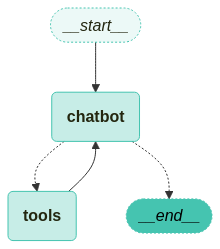

In [10]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(graph)

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

이제 봇에게 훈련 데이터 외의 질문을 할 수 있습니다.

In [11]:
# inputs = {"messages": "테디노트 YouTube 채널에 대해서 검색해 줘"}
inputs = {"messages": "kt 5G 요금제 크루즈 로밍에 대해 알려주세요."}

for event in graph.stream(inputs, stream_mode="values"):
    for key, value in event.items():
        print(f"\n==============\nSTEP: {key}\n==============\n")
        # display_message_tree(value["messages"][-1])
        print(value[-1])


STEP: messages

content='kt 5G 요금제 크루즈 로밍에 대해 알려주세요.' additional_kwargs={} response_metadata={} id='beee6bf6-f191-4841-b8f3-ecc9479eade4'

STEP: messages

content='' additional_kwargs={'tool_calls': [{'id': 'call_eruHgIR5k20lbj1RLhX7vX3F', 'function': {'arguments': '{"query":"kt 5G 요금제 크루즈 로밍"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 108, 'total_tokens': 137, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-460af563-b58d-4e3a-bd70-01930138c3c1-0' tool_calls=[{'name': 'tavily_web_search', 'args': {'query': 'kt 5G 요금제 크루즈 로밍'}, 'id': 'call_eruHgIR5k20lbj1RLhX7vX3F', 'type': 'tool_call'}] usage

도구 호출 후 구조에 대한 이미지

![](./image/tool-message-01.png)

- [이전 실행에 대한 LangSmith 추적](https://smith.langchain.com/public/4f82ddfa-a452-40f3-ab09-4eb088b812a4/r)